# OST – Gait Data Preprocessing Notebook

**Author:** Bakhtiyor Sohibnazarov  
**Module:** Final Year Project  

This notebook:

1. Loads raw 3D joint data captured by the OST system.
2. Handles timestamps and derives a clean time base.
3. Runs data quality diagnostics:
   - Missing data per joint
   - Bone-length stability
   - Basic velocity sanity check
4. Interpolates short gaps and smooths joint trajectories using a One Euro filter.
5. Reduces the dataset to key biomechanical joints and exports:
   - A filtered full-joint CSV
   - A reduced preprocessed CSV for analysis notebook


In [17]:
# Install necessary libraries
!pip -q install pandas numpy scipy

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


# FIle Inputs
INPUT_CSV_RAW       = "data/28.11_raw.csv"
OUTPUT_CSV_FILTERED = "output/28.11_filtered.csv"
OUTPUT_CSV_REDUCED  = "output/28.11_preprocessed.csv"

# Interolation 
MAX_INTERP_GAP      = 3

## 3. Load raw data and derive time base

We:
- Load the raw CSV
- Derive `time` using timestamp if present, otherwise from frame index
- Estimate effective FPS


In [57]:
df_raw = pd.read_csv(INPUT_CSV_RAW)
joint_cols = [c for c in df_raw.columns if c.startswith("joint_")]
joint_ids = sorted({int(c.split("_")[1]) for c in joint_cols})

# Timestamp
if 'timestamp' in df_raw.columns:
    t_raw = pd.to_datetime(df_raw['timestamp'], errors="coerce").ffill().bfill()
    time = (t_raw - t_raw.iloc[0]).dt.total_seconds().to_numpy()

    dt = np.diff(time, prepend=time[0])
    bad = dt <= 0
    if bad.any():
        nominal = np.nanmedian(dt[dt > 0])
        if not np.isfinite(nominal):
            nominal = 1/30
        for i in range(1, len(time)):
            if time[i] <= time[i-1]:
                time[i] = time[i-1] + nominal
else:
    fps_guess = 30
    time = np.arange(len(df_raw)) / fps_guess

df_raw["time"] = time

dt = np.diff(time)
fps_effective = 1.0 / np.nanmedian(dt)
print("Effective FPS =", fps_effective)

Effective FPS = 15.035559097265851


## 5. Preprocessing

In [62]:
# ============================================================
# 5. PREPROCESSING — SAVITZKY–GOLAY SMOOTHING
# ============================================================

df = df_raw.copy()
t  = df["time"].to_numpy()

# joint columns only
joint_cols = [c for c in df.columns if c.startswith("joint_")]
n_frames   = len(df)
n_joints   = len(joint_cols) // 3

# Smoothing parameters
WINDOW = 11      # must be odd; adjust if too smooth
POLY   = 3       # polynomial order

print(f"Applying Savitzky–Golay smoothing to {len(joint_cols)} coordinates...")

# smooth all joint coords
for col in joint_cols:
    arr = df[col].astype(float).to_numpy()

    # replace tiny NaN gaps before smoothing
    arr = interpolate_short_gaps(arr, MAX_INTERP_GAP)

    # Savitzky–Golay smoothing
    arr_smooth = savgol_filter(arr, WINDOW, POLY, mode="interp")

    df[col] = arr_smooth

print("Smoothing complete.")

df.to_csv(OUTPUT_CSV_FILTERED, index=False)
print("Saved smoothed dataset →", OUTPUT_CSV_FILTERED)

Applying Savitzky–Golay smoothing to 99 coordinates...
Smoothing complete.
Saved smoothed dataset → output/28.11_filtered.csv


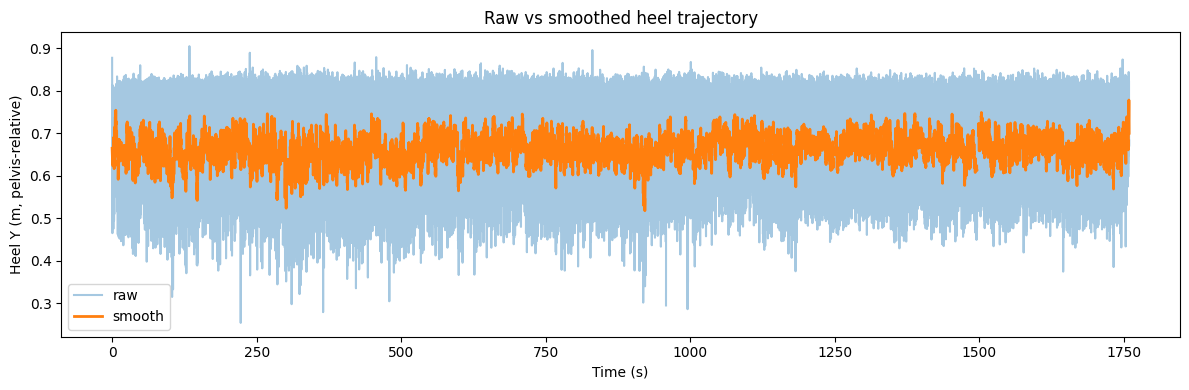

In [63]:
# Example: right heel Y, pelvis-relative
R_heel = df_raw[[f"joint_{RIGHT_HEEL_INDEX}_x",
                 f"joint_{RIGHT_HEEL_INDEX}_y",
                 f"joint_{RIGHT_HEEL_INDEX}_z"]].to_numpy()

L_hip = df_raw[[f"joint_{LEFT_HIP_INDEX}_x",
                f"joint_{LEFT_HIP_INDEX}_y",
                f"joint_{LEFT_HIP_INDEX}_z"]].to_numpy()

R_hip = df_raw[[f"joint_{RIGHT_HIP_INDEX}_x",
                f"joint_{RIGHT_HIP_INDEX}_y",
                f"joint_{RIGHT_HIP_INDEX}_z"]].to_numpy()

pelvis = 0.5 * (L_hip + R_hip)

heel_y_raw = (R_heel - pelvis)[:, 1]  # vertical

# After smoothing (from your SavGol pipeline):
heel_y_smooth = savgol_filter(heel_y_raw, 31, 3, mode="interp")

t = df_raw["time"].to_numpy()

plt.figure(figsize=(12,4))
plt.plot(t, heel_y_raw, alpha=0.4, label="raw")
plt.plot(t, heel_y_smooth, linewidth=2, label="smooth")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Heel Y (m, pelvis-relative)")
plt.title("Raw vs smoothed heel trajectory")
plt.tight_layout()
plt.show()


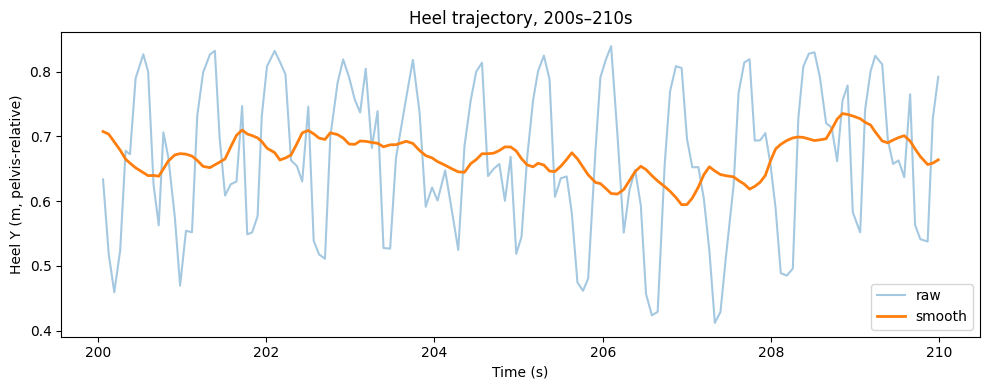

In [60]:
t = df_raw["time"].to_numpy()

# choose a window: e.g. from 200s to 210s
start = 200
dur   = 10
mask = (t >= start) & (t <= start + dur)

plt.figure(figsize=(10,4))
plt.plot(t[mask], heel_y_raw[mask], alpha=0.4, label="raw")
plt.plot(t[mask], heel_y_smooth[mask], linewidth=2, label="smooth")
plt.xlabel("Time (s)")
plt.ylabel("Heel Y (m, pelvis-relative)")
plt.title(f"Heel trajectory, {start}s–{start+dur}s")
plt.legend()
plt.tight_layout()
plt.show()


## 6. Reduce to key joints and export preprocessed dataset

To keep files compact and analysis-focused, we save only:
- Time, optional timestamp
- Selected biomechanically relevant joints
- Validity mask


In [30]:
KEEP = [0, 11, 12, 13, 14, 15, 16,
        23, 24, 25, 26, 27, 28,
        29, 30]

keep_cols = []
for j in KEEP:
    for axis in ["x", "y", "z"]:
        col = f"joint_{j}_{axis}"
        if col in filtered.columns:
            keep_cols.append(col)

final = filtered[["time"] + keep_cols + ["valid"]]
final.to_csv(OUTPUT_CSV_REDUCED, index=False)
print(f"Reduced saved. Final shape: {final.shape}")

KeyError: "['valid'] not in index"